# Analyze output of .hdf5 files of hadrons code
June 12, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools
import sys

In [3]:
import gvar as gv
import h5py

In [4]:
sys.path.append('modules')
from modules_parse_hmc_Grid import *
from modules_measurement import *

In [5]:
# %matplotlib widget

In [6]:
%matplotlib notebook

m_f = 0.02 \
Want m_res < 10^-3

$ m_{phys} = m_f + m_{res} $ 

In [7]:
def f_get_meas_ensemble(run_dir,epoch_list,imag_part=False):
    '''
    Module to extract correlator data for a set of epochs for a run
    '''
    
    lst=[]
    for epoch in epoch_list:
        lst.append(f_get_meas(run_dir,epoch))
    
    keys = lst[0].keys()
    avg_dict={}
    
    for key in keys: 
        if (imag_part==True and key!='m_res'): # If input has imaginary part in array, extract real part
            a1=np.array([i[key][:,0]for i in lst])
        else: 
            a1=np.array([i[key] for i in lst])
            
            
        lgth=a1.shape[1]
        # Average over samples for each t-correlator
        avg_dict[key]=np.array([gv.dataset.avg_data(a1[:,i]) for i in range(lgth)])
    
    return avg_dict


def f_wflow_ensemble(flist,wf_time=90,var='plaq'):
    '''
    Get Wilson flow observables for fixed flow time
    Can plot variation vs epoch    
    '''
    
    obs_list=['flow_time', 'Plaq_density', 'Clover_density', 'top_charge', 'plaq', 'rect', 'ploop']
    assert var in obs_list, "Obsevable %s not in vars list %s"%(var,obs_list)
    
    cols=obs_list+['epoch']
    df=pd.DataFrame(columns=cols)
    
    dict1={}
    
    for count,fname in enumerate(flist):
        flow_vars=f_extract_wilson_flow(fname)
        
        dict1['epoch']=int(fname.split('/')[-1].split('.')[1])
        # Get values at fixed Wilsonflow time

        for key in obs_list:
#             print(key)
            if not key.endswith('ploop'):
                dict1[key] = np.array(flow_vars[key])[wf_time]
            else : 
                dict1[key] = np.array([complex(i,j) for i,j in zip(flow_vars['r_ploop'],flow_vars['i_ploop'])])[wf_time]
    
#         print(dict1)
        ## Append to Dataframe
        df=pd.concat([df,pd.DataFrame(dict1,index=[df.shape[0]+1])])

    return df
    

def f_plot(df,obs):
    '''
    Plot variation with epoch for given observables
    For polyakov loop, also make scatter plot along with absolute value plot
    '''
    
    x=df.epoch.values
    y=df[obs].values

    if obs=='ploop':
        plt.figure()
        plt.scatter(y.real,y.imag,marker='H')
        plt.xlabel('real part')
        plt.ylabel('imag part')
        plt.show()
        
    plt.figure()
    if obs=='ploop':  y=np.abs(y)
    
    plt.plot(x,y,linestyle='',marker='*')
    plt.xlabel('epoch')
    plt.title(obs)
    plt.show()
    
    

def f_plot_compare(df,obs):
    '''
    
    '''
    
    x = df['beta'].values
    y = df[obs].values

    plt.figure()
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',marker='o')
    plt.xlabel('beta')
    plt.ylabel(obs)


def f_avg_obs(df,L):
    
    dict1={}
    for col in df.columns:
        if col =='ploop':
            y=np.abs(df[col].values)
            dict1['mag_ploop']=gv.dataset.avg_data(y)
            dict1['sus_poly'],dict1['kurt_poly']=f_moments(y,L)
            # Complex Polyakov loop
            dict1['ploop']    =[gv.dataset.avg_data(np.real(df[col])),gv.dataset.avg_data(np.imag(df[col]))]

        elif col in ['flow_time','epoch']:
            pass
        else : 
            y=df[col].values
            dict1[col] =gv.dataset.avg_data(y)
            dict1['sus_'+col],dict1['kurt_'+col]=f_moments(y,L)
            
    dict1['num_epochs']=df.shape[0]
    
    return dict1


## 1. Compare runs

In [75]:
# top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_7_hot_start/'
top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_8_cold_start/'


In [76]:
cols=['Plaq_density', 'Clover_density', 'top_charge', 'plaq', 'rect', 'mag_ploop', 'ploop']
df=pd.DataFrame()

dict1={}
for run_dir in glob.glob(top_dir+'meas*/*-tioga/'):

    beta=float(run_dir.split('/')[-3].split('beta-')[-1].split('_')[0])
    mf=float(run_dir.split('/')[-3].split('mf-')[-1])
    L=int(run_dir.split('/')[-3].split('Lx-')[-1].split('_')[0])
    
    dict1['beta']=beta
    dict1['mf']=mf
    
    flist=glob.glob(run_dir+'Wflow*')
    wflow_time=30
    df_epoch=f_wflow_ensemble(flist,wflow_time,'ploop')
    d_avg=f_avg_obs(df_epoch,L)
    
    
#     display(df_epoch)
#     print(d_avg)
    
    for key in d_avg.keys():
        if key!='ploop': dict1[key]=d_avg[key]
        
#     print(dict1)
    df=pd.concat([df,pd.DataFrame(dict1,index=[df.shape[0]+1])])
    
df

,beta,mf,Plaq_density,sus_Plaq_density,kurt_Plaq_density,Clover_density,sus_Clover_density,kurt_Clover_density,top_charge,sus_top_charge,...,plaq,sus_plaq,kurt_plaq,rect,sus_rect,kurt_rect,mag_ploop,sus_poly,kurt_poly,num_epochs
1,11.0,0.1,0.22806(12),0.00594(76),1.55(36)e-07,0.110059(71),0.00201(25),1.47(35)e-07,-0.260(45),818(113),...,0.934080(35),0.000496(64),1.55(36)e-07,0.841091(89),0.00316(40),1.51(36)e-07,0.1189(42),6.95(88),1.53(33)e-07,98
2,11.1,0.1,0.21841(11),0.00466(65),1.70(51)e-07,0.105714(63),0.00157(20),1.55(43)e-07,0.295(51),1025(174),...,0.936867(31),0.000390(54),1.70(51)e-07,0.847504(80),0.00251(34),1.64(50)e-07,0.1233(38),5.80(57),1.13(17)e-07,96
3,11.2,0.1,0.209439(99),0.00379(57),1.86(64)e-07,0.101581(58),0.00130(19),1.76(51)e-07,0.003(26),259(41),...,0.939462(29),0.000316(47),1.86(64)e-07,0.853528(72),0.00204(30),1.78(56)e-07,0.1721(24),2.26(28),1.45(29)e-07,95
4,11.3,0.1,0.201612(95),0.00354(52),1.82(57)e-07,0.098003(53),0.00111(16),1.81(53)e-07,-0.005(23),200(24),...,0.941724(27),0.000296(44),1.82(57)e-07,0.858778(68),0.00183(27),1.85(58)e-07,0.2021(26),2.67(36),1.61(42)e-07,96
5,11.4,0.1,0.194527(64),0.00258(29),1.71(34)e-07,0.094778(37),0.000848(94),1.71(38)e-07,0.023(18),195(24),...,0.943772(19),0.000215(24),1.71(34)e-07,0.863527(47),0.00137(15),1.71(34)e-07,0.2160(18),2.13(23),1.62(32)e-07,153
6,11.5,0.1,0.187950(85),0.00255(32),1.40(29)e-07,0.091752(48),0.00084(11),1.53(37)e-07,-0.002(23),190(29),...,0.945673(24),0.000213(27),1.40(29)e-07,0.867957(62),0.00136(17),1.42(31)e-07,0.2272(28),2.70(35),1.44(42)e-07,87
7,11.6,0.1,0.182096(83),0.00244(34),1.61(44)e-07,0.089072(48),0.00083(12),1.60(40)e-07,-0.011(21),164(22),...,0.947365(24),0.000204(29),1.61(44)e-07,0.871898(61),0.00132(19),1.61(43)e-07,0.2503(21),1.51(23),1.76(64)e-07,87
8,11.7,0.1,0.176430(73),0.00192(33),2.15(74)e-07,0.086434(46),0.00074(12),2.02(67)e-07,0.027(19),123(19),...,0.949003(21),0.000160(28),2.15(74)e-07,0.875738(56),0.00110(19),2.05(68)e-07,0.2727(23),1.90(26),1.53(37)e-07,87
9,11.8,0.1,0.171412(76),0.00228(29),1.50(34)e-07,0.084150(44),0.00078(11),1.66(42)e-07,-0.003(16),107(15),...,0.950453(22),0.000191(24),1.50(34)e-07,0.879117(56),0.00125(16),1.54(36)e-07,0.2754(21),1.77(23),1.54(38)e-07,97
10,11.9,0.1,0.166690(61),0.00164(21),1.61(37)e-07,0.081933(36),0.000573(81),1.88(54)e-07,0.034(15),102(15),...,0.951818(18),0.000137(17),1.61(37)e-07,0.882332(45),0.00090(12),1.75(45)e-07,0.3033(21),2.03(28),1.79(52)e-07,109


<IPython.core.display.Javascript object>


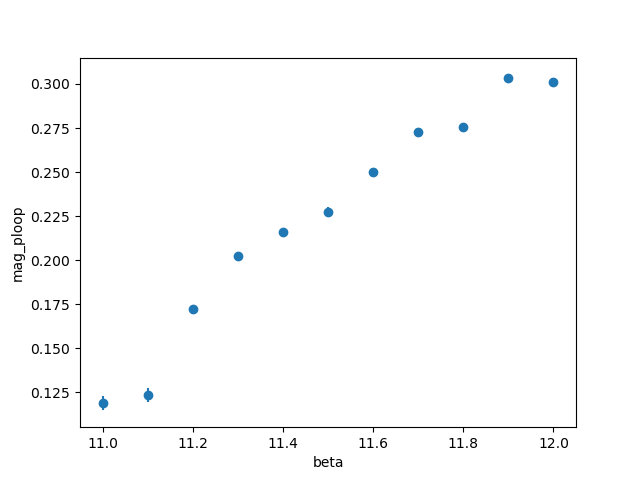

In [77]:
f_plot_compare(df,'mag_ploop')

In [11]:
# obs='top_charge'
# f_plot_compare(df,obs)
# plt.savefig('wflow_%s.pdf'%(obs))

<IPython.core.display.Javascript object>


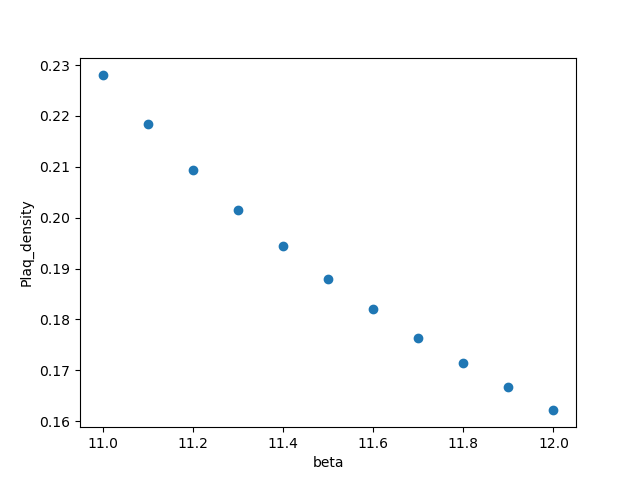

<IPython.core.display.Javascript object>


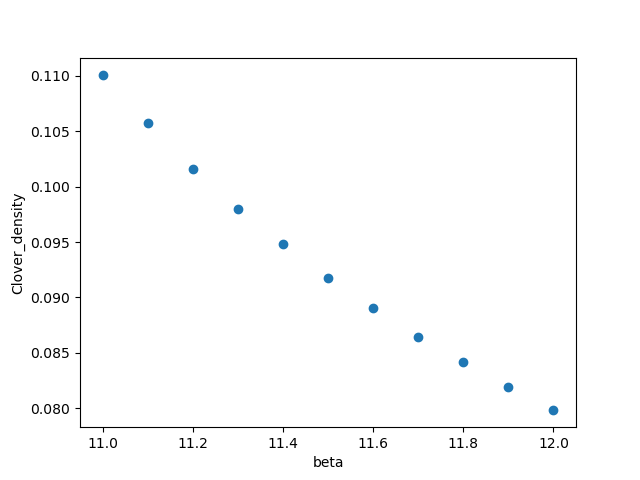

<IPython.core.display.Javascript object>


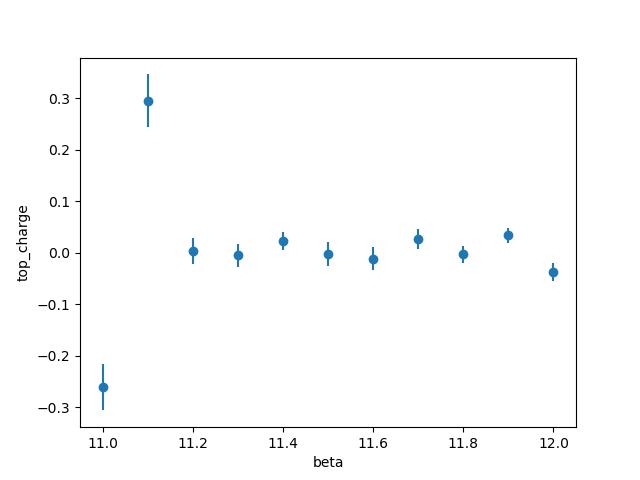

<IPython.core.display.Javascript object>


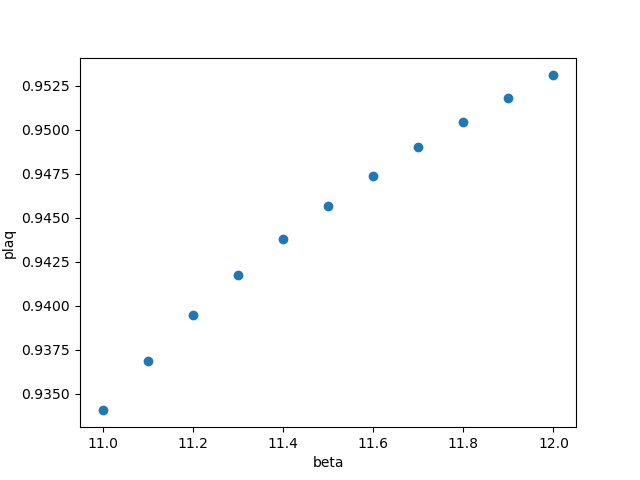

<IPython.core.display.Javascript object>


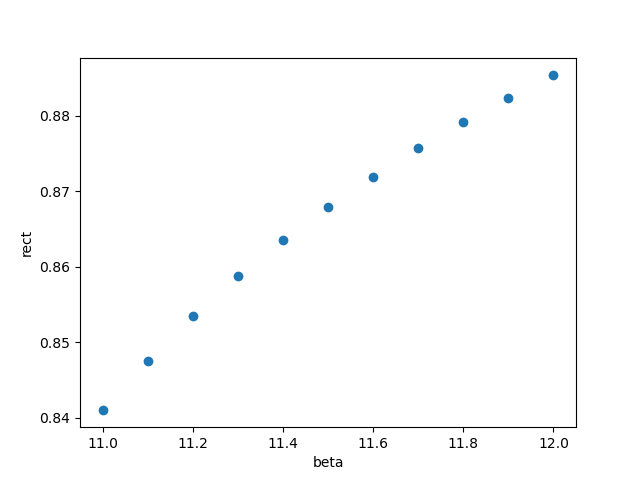

<IPython.core.display.Javascript object>


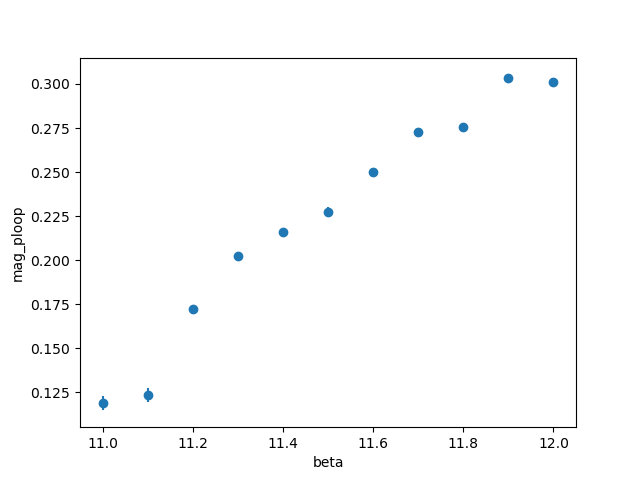

<IPython.core.display.Javascript object>


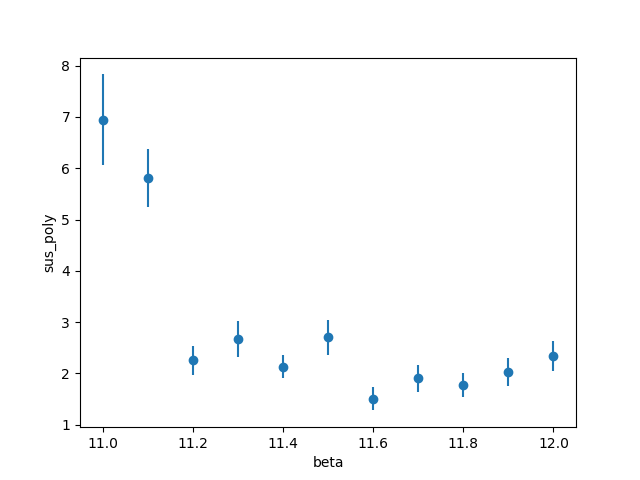

In [78]:
for obs in ['Plaq_density','Clover_density','top_charge','plaq','rect','mag_ploop','sus_poly']:
    f_plot_compare(df,obs)
#     plt.savefig('wflow_%s.pdf'%(obs))

In [82]:
df

,beta,mf,Plaq_density,sus_Plaq_density,kurt_Plaq_density,Clover_density,sus_Clover_density,kurt_Clover_density,top_charge,sus_top_charge,...,plaq,sus_plaq,kurt_plaq,rect,sus_rect,kurt_rect,mag_ploop,sus_poly,kurt_poly,num_epochs
1,11.0,0.1,0.22806(12),0.00594(76),1.55(36)e-07,0.110059(71),0.00201(25),1.47(35)e-07,-0.260(45),818(113),...,0.934080(35),0.000496(64),1.55(36)e-07,0.841091(89),0.00316(40),1.51(36)e-07,0.1189(42),6.95(88),1.53(33)e-07,98
2,11.1,0.1,0.21841(11),0.00466(65),1.70(51)e-07,0.105714(63),0.00157(20),1.55(43)e-07,0.295(51),1025(174),...,0.936867(31),0.000390(54),1.70(51)e-07,0.847504(80),0.00251(34),1.64(50)e-07,0.1233(38),5.80(57),1.13(17)e-07,96
3,11.2,0.1,0.209439(99),0.00379(57),1.86(64)e-07,0.101581(58),0.00130(19),1.76(51)e-07,0.003(26),259(41),...,0.939462(29),0.000316(47),1.86(64)e-07,0.853528(72),0.00204(30),1.78(56)e-07,0.1721(24),2.26(28),1.45(29)e-07,95
4,11.3,0.1,0.201612(95),0.00354(52),1.82(57)e-07,0.098003(53),0.00111(16),1.81(53)e-07,-0.005(23),200(24),...,0.941724(27),0.000296(44),1.82(57)e-07,0.858778(68),0.00183(27),1.85(58)e-07,0.2021(26),2.67(36),1.61(42)e-07,96
5,11.4,0.1,0.194527(64),0.00258(29),1.71(34)e-07,0.094778(37),0.000848(94),1.71(38)e-07,0.023(18),195(24),...,0.943772(19),0.000215(24),1.71(34)e-07,0.863527(47),0.00137(15),1.71(34)e-07,0.2160(18),2.13(23),1.62(32)e-07,153
6,11.5,0.1,0.187950(85),0.00255(32),1.40(29)e-07,0.091752(48),0.00084(11),1.53(37)e-07,-0.002(23),190(29),...,0.945673(24),0.000213(27),1.40(29)e-07,0.867957(62),0.00136(17),1.42(31)e-07,0.2272(28),2.70(35),1.44(42)e-07,87
7,11.6,0.1,0.182096(83),0.00244(34),1.61(44)e-07,0.089072(48),0.00083(12),1.60(40)e-07,-0.011(21),164(22),...,0.947365(24),0.000204(29),1.61(44)e-07,0.871898(61),0.00132(19),1.61(43)e-07,0.2503(21),1.51(23),1.76(64)e-07,87
8,11.7,0.1,0.176430(73),0.00192(33),2.15(74)e-07,0.086434(46),0.00074(12),2.02(67)e-07,0.027(19),123(19),...,0.949003(21),0.000160(28),2.15(74)e-07,0.875738(56),0.00110(19),2.05(68)e-07,0.2727(23),1.90(26),1.53(37)e-07,87
9,11.8,0.1,0.171412(76),0.00228(29),1.50(34)e-07,0.084150(44),0.00078(11),1.66(42)e-07,-0.003(16),107(15),...,0.950453(22),0.000191(24),1.50(34)e-07,0.879117(56),0.00125(16),1.54(36)e-07,0.2754(21),1.77(23),1.54(38)e-07,97
10,11.9,0.1,0.166690(61),0.00164(21),1.61(37)e-07,0.081933(36),0.000573(81),1.88(54)e-07,0.034(15),102(15),...,0.951818(18),0.000137(17),1.61(37)e-07,0.882332(45),0.00090(12),1.75(45)e-07,0.3033(21),2.03(28),1.79(52)e-07,109


## 2. Explore ensemble
View variation for a set of configs for specific beta, mf

In [99]:
## Choose specific beta from above dataframe

beta=12.0
run_dir=glob.glob(top_dir+'meas_run_Lx-16_Lt-8_Ls-16_beta-{0}_mf-0.1/*-tioga'.format(beta))[0]+'/'
print(run_dir)

/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_8_cold_start/meas_run_Lx-16_Lt-8_Ls-16_beta-12.0_mf-0.1/091023_062956-tioga/


In [100]:
# # Alternatively, provide the full directory path to specific run
# run_dir=glob.glob('/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_7_cold_start/meas_run_Lx-16_Lt-8_Ls-16_beta-11.9_mf-0.1/*-tioga')[0]+'/'
# print(run_dir)


### Correlator plots

<IPython.core.display.Javascript object>


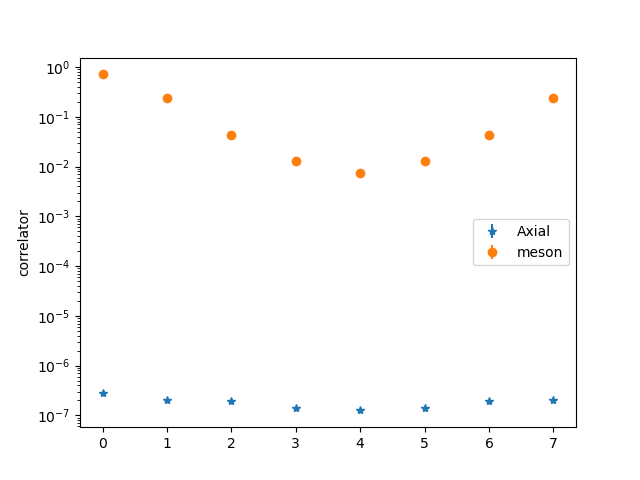

<IPython.core.display.Javascript object>


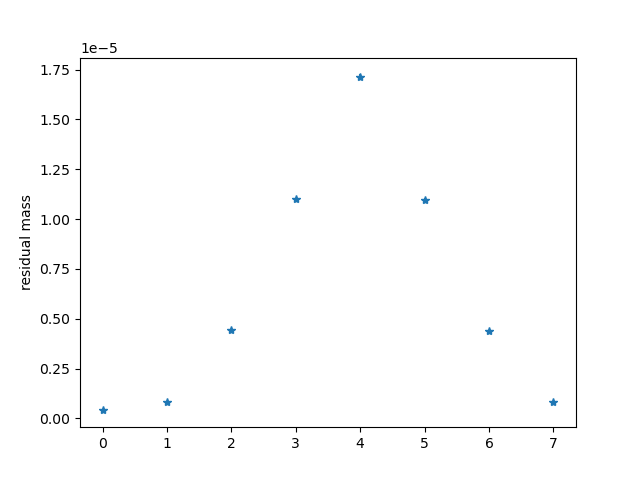

In [101]:
epoch_list=[i.split('/')[-1].split('.')[1] for i in glob.glob(run_dir+'eta_*')]

avg_dict=f_get_meas_ensemble(run_dir,epoch_list)
f_plot_mres(avg_dict,plot_ensemble=True,plot_corr=True)


### Wilson flow 

In [102]:
flist=glob.glob(run_dir+'Wflow*')
wflow_time=49

df_epoch=f_wflow_ensemble(flist,wflow_time,'ploop')
df_epoch

,flow_time,Plaq_density,Clover_density,top_charge,plaq,rect,ploop,epoch
1,0.5,0.158342,0.108087,0.195137,0.982406,0.949553,0.396487-0.002827j,375
2,0.5,0.159575,0.108620,0.077721,0.982269,0.949221,0.371877-0.000290j,380
3,0.5,0.158999,0.108045,-0.106549,0.982333,0.949437,0.455116+0.002993j,385
4,0.5,0.157918,0.107474,0.045222,0.982454,0.949751,0.406360+0.000097j,390
5,0.5,0.158103,0.107602,-0.114499,0.982433,0.949688,0.402210-0.008630j,395
...,...,...,...,...,...,...,...,...
108,0.5,0.159240,0.108507,0.052816,0.982307,0.949304,0.346889-0.021407j,910
109,0.5,0.158832,0.107981,-0.055298,0.982352,0.949485,0.383203-0.000351j,915
110,0.5,0.157198,0.106640,0.068325,0.982534,0.950040,0.406081+0.003043j,920
111,0.5,0.158502,0.107758,0.041801,0.982389,0.949583,0.388835-0.010063j,925


<IPython.core.display.Javascript object>


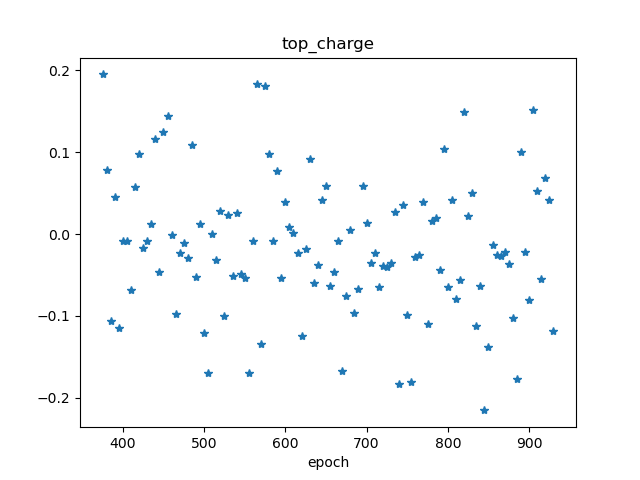

In [103]:
# f_plot(df_epoch,'ploop')
f_plot(df_epoch,'top_charge')
plt.savefig('fig_output/top_charge_beta12.0_wflow50.pdf')

## 3. Explore single measurement
View variation for a specific config

In [19]:
run_dir=glob.glob(top_dir+'meas_run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1/*-tioga')[0]+'/'
print(run_dir)

/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_7_hot_start/meas_run_Lx-16_Lt-8_Ls-16_beta-11.0_mf-0.1/090723_054620-tioga/


In [20]:
# Alternatively, provide the full directory path to specific run
# run_dir=glob.glob('/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_july12/runs/meas_7_hot_start/meas_run_Lx-16_Lt-8_Ls-16_beta-11.4_mf-0.1/*-tioga')[0]+'/'
# print(run_dir)


In [21]:
epoch_list=[i.split('/')[-1].split('.')[1] for i in glob.glob(run_dir+'eta_*')]
print(epoch_list)

['255', '260', '265', '270', '275', '280', '285', '290', '295', '300', '305', '310', '315', '320', '325', '330', '335', '340', '345', '350', '355', '360', '365', '370', '375', '380', '385', '390', '395', '400', '405', '410', '415', '420', '425', '430', '435', '440', '445', '450', '455', '460', '465', '470', '475', '480', '485', '490', '495', '500', '505', '510', '515', '520', '525', '530', '535', '540', '545', '550', '555', '560', '565', '570', '575', '580', '585', '590', '595', '600', '605', '610', '615', '620', '625', '630', '635', '640', '645', '650', '655', '660', '665', '670', '675', '680', '685', '690', '695', '700', '705', '710', '715', '720', '725', '730', '735', '740', '745', '750', '755', '760', '765', '770', '775', '780', '785', '790', '795', '800', '805', '810', '815', '820', '825', '830', '835', '840', '845', '850', '855', '860', '865', '870', '875', '880', '885', '890', '895', '900', '905', '910', '915', '920', '925', '930', '935', '940', '945', '950', '955', '960', '965'

### Correlators

In [ ]:
epoch=1315
print("Epoch",epoch)

In [ ]:
m1=f_get_meas(run_dir,epoch,True)
f_plot_mres(m1,False)
plt.show()

### Wilson flow

In [ ]:
fname=run_dir+'Wflow_.{0}.h5'.format(epoch)

flow_vars=f_extract_wilson_flow(fname)

# Plot Wilson flow results
keys=['flow_time','Plaq_density','Clover_density','top_charge','plaq','rect','r_ploop','i_ploop']

plt.figure()
for key,marker in zip(keys,itertools.cycle('>^*sDHPdpx_')):
    plt.plot(flow_vars[key],linestyle='',marker=marker,label=key)
    
plt.legend(loc='best')
